# CS4120 Final Project
### Junhao Lin, Xianrui She

### 1. Data Display & Preprocessing

In [5]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [6]:
# reading the data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [7]:
# data preprocessing
# data preview
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
# cut out the id columns and keep only texts and labels
train = train.iloc[:, -3:]

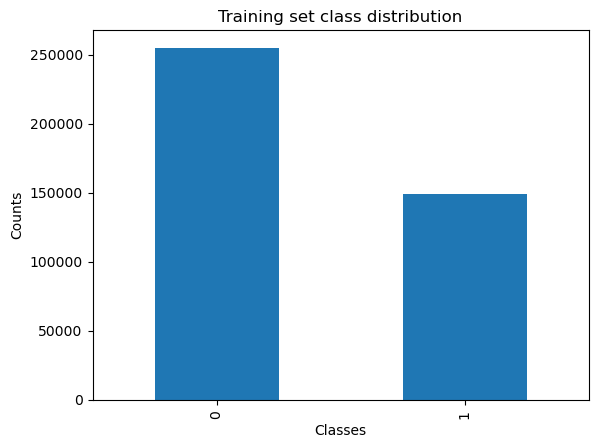

In [9]:
# class distribution
train['is_duplicate'].value_counts().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Training set class distribution')
plt.show()

In [40]:
# cropping the training data so that classes are balanced (50/50)
min_length = len(train[train['is_duplicate']  == 1])
train_0 = train[train['is_duplicate']  == 0].sample(min_length, random_state=42)
# train_balanced = pd.concat([train_0, train[train['is_duplicate']  == 1]])
# train_balanced = pd.concat([train_0[:min_length // 5], train[train['is_duplicate']  == 1][:min_length // 5]])
train_balanced = pd.concat([train_0, train[train['is_duplicate']  == 1]])

In [57]:
train_balanced.isna().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

In [56]:
train_balanced.dropna(inplace=True)

In [43]:
def normalize(text:str) -> list:
    ''' Function to tokenize our data correctly

    - input: text(str), unprocessed material
    - output: result(list), processed material
    '''
    # print(text)
    text = text.replace('%', ' percent ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('¥', ' yuan ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    text = text.replace('[math]', '')
    
    # Replacing some numbers with string etextuivalents (not perfect, can be done better to account for more cases)
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # convert all stemmed words to its original form
    stemmer = SnowballStemmer('english')
    #text = stemmer.stem(text)
    tokens = word_tokenize(text)

    for i in range(len(tokens)):
        tokens[i] = stemmer.stem(tokens[i])
    
    return ' '.join(tokens)

In [14]:
# test for normalize
str1 = "I exchanged 10$ to 70.9999¥"

normalize(str1)

'i exchang 10 $ to 70.9999 yuan'

In [60]:
# tokenize sentences in training data 
train_q1 = list(train_balanced['question1'].apply(normalize))
train_q2 = list(train_balanced['question2'].apply(normalize))

In [61]:
# vectorization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
q1_vec = vectorizer.fit_transform(train_q1)
q2_vec = vectorizer.fit_transform(train_q2)

In [62]:
from scipy.sparse import hstack
X = hstack((q1_vec, q2_vec))

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X, train_balanced['is_duplicate'], test_size=0.2, random_state=42)

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model_1 = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, n_jobs=4, alpha=0.0001, early_stopping=True)
model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
print('The accuracy for baseline logistic regression:', accuracy_score(y_test, y_pred))

The accuracy for baseline logistic regression: 0.7138933087681099


In [65]:
from sklearn.model_selection import GridSearchCV

params = {'penalty':['l1', 'l2'], 'tol':[1e-3, 1e-4, 1e-5], 'alpha':[0.0001, 0.005, 0.001]}
sgd = SGDClassifier(loss='log_loss', max_iter=1000, n_jobs=4, early_stopping=True)
clf = GridSearchCV(sgd, params)
clf.fit(X_train,y_train)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, loss='log_loss',
                                     n_jobs=4),
             param_grid={'alpha': [0.0001, 0.005, 0.001],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.0001, 1e-05]})

In [74]:
best_params = clf.best_params_

In [75]:
model_2 = SGDClassifier(loss='log_loss', max_iter=1000, tol=best_params['tol'], n_jobs=4, alpha=best_params['alpha'], penalty='l2', early_stopping=True)
model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test)
print('The accuracy for baseline logistic regression:', accuracy_score(y_test, y_pred))

The accuracy for baseline logistic regression: 0.7158864416715518


In [72]:
y_pred_prob = model_2.predict_proba(X_test)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in thresholds:
    y_pred = [1 if y_hat_val[1] > i else 0 for y_hat_val in y_pred_prob]
    print(f'Accuracy for threshold = {i}:', accuracy_score(y_test,y_pred))

Accuracy for threshold = 0.3: 0.662993049158362
Accuracy for threshold = 0.4: 0.700460597939871
Accuracy for threshold = 0.5: 0.7153839711916925
Accuracy for threshold = 0.6: 0.6934762582698266
Accuracy for threshold = 0.7: 0.6499120676660246


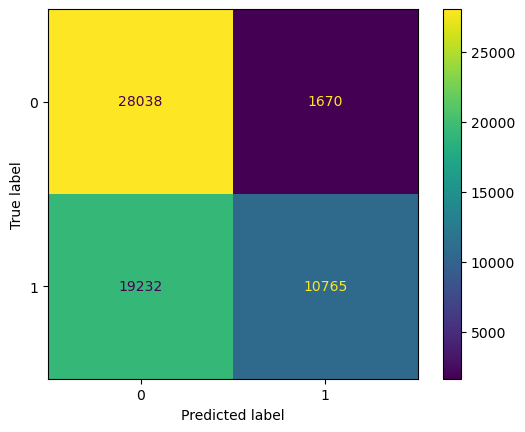

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()